### Imports

In [105]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from numpy import sort
import datetime
import collections
from collections import OrderedDict
from matplotlib import pyplot

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier

pd.set_option('display.max_columns', None)

### Evaluation functions

In [27]:
def save_file(predictions, filename):
    predictions.to_csv('./Results/' + filename, index=False)
    
def xstr(s):
    if s is None:
        return ''
    return str(s)

def add_results(today, algorithm, author, params, classification_rate, filename, processing_time=None, notes=None):
    date = '{:02d}-{:02d}-{:02d}'.format(today.year, today.month, today.day)
    timestamp = '{:02d}:{:02d}:{:02d}'.format(today.hour, today.minute, today.second)
    row = '|'.join([date, timestamp, algorithm, author, str(params), str(classification_rate), filename, xstr(notes)])
    with open('./results.csv','a') as file:
        file.write('|'.join([date, timestamp, algorithm, author, str(params), str(classification_rate), filename, xstr(processing_time), xstr(notes) + '\n']))

In [28]:
def evaluate(ids, true_values, predictions, algorithm, author, params, processing_time=None, notes=None):
    evaluation_df = pd.DataFrame(list(ids), columns=['id'])
    evaluation_df['true_values'] = list(true_values)
    evaluation_df['predicted_values'] = list(predictions)
    correct_predictions = len(evaluation_df[evaluation_df['true_values'] == evaluation_df['predicted_values']])
    classification_rate = correct_predictions / len(predictions)
    today = datetime.datetime.now()
    date = '{:02d}{:02d}{:02d}-{:02d}{:02d}{:02d}'.format(today.year, today.month, today.day, today.hour, today.minute, today.second)
    filename = '{}_{}.csv'.format(date, '-'.join(algorithm.split()))
    save_file(evaluation_df.drop(columns='true_values', axis=1).rename(columns={'predicted_values': 'status_group'}), filename=filename)
    add_results(today=today, algorithm=algorithm, author=author, params=params, classification_rate=classification_rate, filename=filename, processing_time=processing_time, notes=notes)
    return classification_rate

### Load the data

In [29]:
train = pd.read_csv('./Data/train_cleaned_v0.2.csv')
train_raw = pd.read_csv('./Data/training_set_values.csv')

train = train.merge(train_raw[['id','extraction_type_group','extraction_type_class','payment','quality_group','source_class','source_type','waterpoint_type_group','management_group','quantity_group','wpt_name']],on='id')

labels = pd.read_csv('./Data/training_set_labels.csv')
train = train.merge(labels, on="id")
target = train.pop("status_group")

train.head()


,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,longitude_imp_normal,longitude_imp_random_choice,latitude_imp_normal,latitude_imp_random_choice,gps_height_imp_normal,gps_height_imp_random_choice,population_imp_normal,population_imp_random_choice,construction_year_imp_normal,construction_year_imp_random_choice,amount_tsh_imp_normal,amount_tsh_imp_random_choice,operation_years,operation_years_imp_normal,operation_years_imp_random_choice,extraction_type_group,extraction_type_class,payment,quality_group,source_class,source_type,waterpoint_type_group,management_group,quantity_group,wpt_name
0,69572,8.699681,Roman,1390.0,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,4.700480,True,VWC,Roman,False,1999.0,gravity,vwc,annually,soft,enough,spring,communal standpipe,34.938093,34.938093,-9.856322,-9.856322,1390.000000,1390.0,4.700480,4.700480,1999.000000,1999.0,8.699681,8.699681,12,12,12,gravity,gravity,pay annually,good,groundwater,spring,communal standpipe,user-group,enough,none
1,8776,5.826890,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,5.638355,Missing,Other,Missing,True,2010.0,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,34.698766,34.698766,-2.147466,-2.147466,1399.000000,1399.0,5.638355,5.638355,2010.000000,2010.0,6.520780,6.908755,3,3,3,gravity,gravity,never pay,good,surface,rainwater harvesting,communal standpipe,user-group,insufficient,Zahanati
2,34310,3.258097,Lottery Club,686.0,World vision,37.460664,-3.821329,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,5.525453,True,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,37.460664,37.460664,-3.821329,-3.821329,686.000000,686.0,5.525453,5.525453,2009.000000,2009.0,3.258097,3.258097,4,4,4,gravity,gravity,pay per bucket,good,surface,dam,communal standpipe,user-group,enough,Kwa Mahundi
3,67743,5.420290,Unicef,263.0,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,4.077537,True,VWC,Missing,True,1986.0,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,38.486161,38.486161,-11.155298,-11.155298,263.000000,263.0,4.077537,4.077537,1986.000000,1986.0,6.906485,3.931826,27,27,27,submersible,submersible,never pay,good,groundwater,borehole,communal standpipe,user-group,dry,Zahanati Ya Nanyumbu
4,19728,5.301670,Action In A,1167.0,Artisan,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,5.017280,True,Missing,Missing,True,2000.0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,31.130847,31.130847,-1.825359,-1.825359,1240.292552,455.0,2.575311,0.693147,2016.001834,2006.0,2.826742,2.397895,11,-5,5,gravity,gravity,never pay,good,surface,rainwater harvesting,communal standpipe,other,seasonal,Shuleni


### Global variables and model parameters

In [91]:
# Features that will be considered in the model
remove_features = 'status_group longitude_imp_random_choice latitude_imp_random_choice amount_tsh_imp_random_choice gps_height_imp_random_choice population_imp_random_choice construction_year_imp_random_choice longitude latitude amount_tsh gps_height population construction_year longitude_imp_mean-median'.split()
features = [feature for feature in list(train.columns) if feature not in remove_features]

# These features will be scaled
num_features=['latitude_imp_normal','longitude_imp_normal', 'gps_height_imp_normal', 'population_imp_normal', 'amount_tsh_imp_normal', 'construction_year_imp_normal', 'operation_years_imp_normal']

# These features will be factorized
cat_features = ['funder','installer','basin','region','public_meeting','scheme_management','permit','extraction_type','management','payment_type','water_quality','payment_type','quantity','source','waterpoint_type','ward','subvillage','lga','scheme_name','extraction_type_group','extraction_type_class','payment','quality_group','source_class','source_type','waterpoint_type_group','management_group','quantity_group','wpt_name']

# Target variable
label = 'status_group'

# ID variable (used for merging and submitting results)
id_variable = 'id'

# Parameters for train/test split
seed = 7
test_size = 0.33

# Model parameters
params = {'n_estimators': 500, 'max_depth': 10, 'num_class': 3, 'objective': 'multi:softmax'}


### Data preparation

In [31]:
# Factorize features for evaluations

for var in cat_features:
    train[var] = pd.factorize(train[var])[0]

train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,longitude_imp_normal,longitude_imp_random_choice,latitude_imp_normal,latitude_imp_random_choice,gps_height_imp_normal,gps_height_imp_random_choice,population_imp_normal,population_imp_random_choice,construction_year_imp_normal,construction_year_imp_random_choice,amount_tsh_imp_normal,amount_tsh_imp_random_choice,operation_years,operation_years_imp_normal,operation_years_imp_random_choice,extraction_type_group,extraction_type_class,payment,quality_group,source_class,source_type,waterpoint_type_group,management_group,quantity_group,wpt_name
0,69572,8.699681,0,1390.0,0,34.938093,-9.856322,0,0,0,11,5,0,0,4.700480,0,0,0,0,1999.0,0,0,0,0,0,0,0,34.938093,34.938093,-9.856322,-9.856322,1390.000000,1390.0,4.700480,4.700480,1999.000000,1999.0,8.699681,8.699681,12,12,12,0,0,0,0,0,0,0,0,0,0
1,8776,5.826890,1,1399.0,1,34.698766,-2.147466,1,1,1,20,2,1,1,5.638355,1,1,1,1,2010.0,0,1,1,0,1,1,0,34.698766,34.698766,-2.147466,-2.147466,1399.000000,1399.0,5.638355,5.638355,2010.000000,2010.0,6.520780,6.908755,3,3,3,0,0,1,0,1,1,0,0,1,1
2,34310,3.258097,2,686.0,2,37.460664,-3.821329,2,2,2,21,4,2,2,5.525453,0,0,2,1,2009.0,0,0,2,0,0,2,1,37.460664,37.460664,-3.821329,-3.821329,686.000000,686.0,5.525453,5.525453,2009.000000,2009.0,3.258097,3.258097,4,4,4,0,0,2,0,1,2,0,0,0,2
3,67743,5.420290,3,263.0,3,38.486161,-11.155298,3,3,3,90,63,3,3,4.077537,0,0,1,1,1986.0,1,0,1,0,2,3,1,38.486161,38.486161,-11.155298,-11.155298,263.000000,263.0,4.077537,4.077537,1986.000000,1986.0,6.906485,3.931826,27,27,27,1,1,1,0,0,3,0,0,2,3
4,19728,5.301670,4,1167.0,4,31.130847,-1.825359,1,4,4,18,1,4,4,5.017280,0,2,1,1,2000.0,0,2,1,0,3,1,0,31.130847,31.130847,-1.825359,-1.825359,1240.292552,455.0,2.575311,0.693147,2016.001834,2006.0,2.826742,2.397895,11,-5,5,0,0,1,0,1,1,0,1,3,4


In [32]:
# Factorize target dataframe

labels, uniques = target.factorize()
target = pd.Series(labels)
target.head()

0    0
1    0
2    0
3    1
4    0
dtype: int64

### Train-Test-Split

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size=test_size, random_state=seed, stratify=target)

In [34]:
train_ids = X_train[id_variable]
test_ids = X_test[id_variable]

### Build and fit the model - Built-in multiclass classification

In [92]:
# Build the model and fit it to the train split

start_time = datetime.datetime.now()
model = XGBClassifier(**params).fit(X_train, Y_train)
stop_time = datetime.datetime.now()
processing_time = (stop_time - start_time).seconds
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

#### Feature importances measurements

In [93]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(train.columns), importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: quantity             Importance: 0.1599999964237213
Variable: extraction_type_class Importance: 0.10999999940395355
Variable: waterpoint_type      Importance: 0.07000000029802322
Variable: region               Importance: 0.029999999329447746
Variable: construction_year    Importance: 0.029999999329447746
Variable: extraction_type      Importance: 0.029999999329447746
Variable: amount_tsh           Importance: 0.019999999552965164
Variable: basin                Importance: 0.019999999552965164
Variable: region_code          Importance: 0.019999999552965164
Variable: district_code        Importance: 0.019999999552965164
Variable: lga                  Importance: 0.019999999552965164
Variable: public_meeting       Importance: 0.019999999552965164
Variable: scheme_management    Importance: 0.019999999552965164
Variable: permit               Importance: 0.019999999552965164
Variable: management           Importance: 0.019999999552965164
Variable: payment_type         Importance: 

In [94]:
# Gain: Implies the relative contribution of the corresponding feature to the model calculated by 
# taking each feature’s contribution for each tree in the model. 
# A higher value of this metric when compared to another feature implies 
# it is more important for generating a prediction
# -> Improvement in accuracy brought by a feature to the branches it is on

gain = model.get_booster().get_score(importance_type= 'gain')
gain = sorted(gain.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
gain

[('quantity', 13.780866532566206),
 ('extraction_type_class', 9.38324336688675),
 ('waterpoint_type', 6.482798307211789),
 ('region', 2.7881886211778397),
 ('extraction_type', 2.7098540455420848),
 ('construction_year', 2.2785949187847003),
 ('source', 2.172791920104939),
 ('public_meeting', 2.0181051456803454),
 ('payment_type', 1.9645223890687473),
 ('lga', 1.837813698892854),
 ('basin', 1.8252688837611732),
 ('quality_group', 1.7556669517943886),
 ('region_code', 1.7264745697056756),
 ('management', 1.6929950168414238),
 ('operation_years', 1.627331512902083),
 ('district_code', 1.5332345464587727),
 ('source_type', 1.5110893542837716),
 ('source_class', 1.4474325195530047),
 ('scheme_management', 1.4266802933320708),
 ('permit', 1.3987005964540509),
 ('extraction_type_group', 1.3915223094128089),
 ('amount_tsh', 1.3385613095538287),
 ('management_group', 1.3334451070096562),
 ('scheme_name', 1.2394134543698205),
 ('longitude', 1.1595343994598077),
 ('latitude', 1.1530423317042988),

In [95]:
total_gain = model.get_booster().get_score(importance_type= 'total_gain')
total_gain = sorted(total_gain.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
total_gain

[('quantity', 46923.85054338793),
 ('longitude', 20488.972838454803),
 ('latitude', 20189.771228142272),
 ('waterpoint_type', 17302.588681948266),
 ('id', 14274.123615829205),
 ('subvillage', 13117.363939964505),
 ('wpt_name', 12405.319590687122),
 ('ward', 11314.590415972089),
 ('lga', 11047.098144044945),
 ('amount_tsh_imp_normal', 9894.497191404407),
 ('gps_height', 9703.105219546647),
 ('funder', 9283.853126128943),
 ('construction_year', 9082.479346275815),
 ('extraction_type', 8698.631486190092),
 ('installer', 8425.393116261868),
 ('scheme_name', 8406.941460990492),
 ('gps_height_imp_normal', 7942.3475526770835),
 ('population_imp_normal', 7918.4027363951145),
 ('region', 7048.540834337578),
 ('extraction_type_class', 6915.450361395535),
 ('amount_tsh', 6890.91362158311),
 ('population', 6848.430825650134),
 ('payment_type', 6834.573391570172),
 ('gps_height_imp_random_choice', 6827.935586886211),
 ('construction_year_imp_normal', 6156.658438004852),
 ('source', 5251.63807089363

In [96]:
# Coverage: Measures the relative quantity of observations concerned by a feature

cover = model.get_booster().get_score(importance_type= 'cover')
cover = sorted(cover.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
cover

[('extraction_type_class', 1131.882724725236),
 ('extraction_type_group', 953.4581473977611),
 ('waterpoint_type', 924.9542375836872),
 ('quantity', 922.5952817502233),
 ('payment_type', 708.9407677755038),
 ('water_quality', 662.1419054802427),
 ('extraction_type', 652.8320069215238),
 ('latitude_imp_random_choice', 509.20324637386403),
 ('operation_years', 431.8922545267944),
 ('quality_group', 395.3217020128059),
 ('source', 385.20820057037974),
 ('management_group', 359.01279613670044),
 ('public_meeting', 353.44499562151424),
 ('district_code', 346.32478544752917),
 ('region', 342.6075919327182),
 ('region_code', 339.0148536252461),
 ('source_class', 335.7237664100453),
 ('longitude_imp_normal', 331.8051040188172),
 ('lga', 327.7949303235957),
 ('gps_height_imp_normal', 325.61063963999885),
 ('longitude', 305.5701242740778),
 ('longitude_imp_random_choice', 299.24991434364205),
 ('installer', 295.7657700567628),
 ('latitude', 286.27771529677904),
 ('management', 281.4539239652924)

In [97]:
total_cover = model.get_booster().get_score(importance_type= 'total_cover')
total_cover = sorted(total_cover.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
total_cover

[('longitude', 5399424.095922954),
 ('latitude', 5012722.794846601),
 ('id', 4498609.271482763),
 ('amount_tsh_imp_normal', 3990995.023021271),
 ('gps_height_imp_normal', 3518548.5719498275),
 ('quantity', 3141436.9343595104),
 ('population_imp_normal', 2887083.0268723825),
 ('subvillage', 2807844.5957794823),
 ('ward', 2748820.9220156344),
 ('wpt_name', 2699093.847139601),
 ('gps_height_imp_random_choice', 2503370.813185268),
 ('waterpoint_type', 2468702.8601108612),
 ('payment_type', 2466404.9310909775),
 ('gps_height', 2261307.194302516),
 ('installer', 2257284.3570732134),
 ('funder', 2197858.5094586024),
 ('extraction_type', 2095590.7422180914),
 ('lga', 1970375.3261751335),
 ('scheme_name', 1846980.7879502084),
 ('construction_year_imp_normal', 1617835.6542824463),
 ('amount_tsh', 1257387.1764711768),
 ('population', 1212798.4465864885),
 ('district_code', 1097156.9202977724),
 ('population_imp_random_choice', 955146.1293026309),
 ('source', 931048.2207786079),
 ('operation_years

In [98]:
# Weight (as in F Score (importance plot below)): Percentage representing the relative number of times 
# a particular feature occurs in the trees of the model

weights = model.get_booster().get_score(importance_type= 'weight')
weights = sorted(weights.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
weights

[('id', 23269),
 ('wpt_name', 19693),
 ('subvillage', 19250),
 ('longitude', 17670),
 ('latitude', 17510),
 ('amount_tsh_imp_normal', 14933),
 ('ward', 12981),
 ('population_imp_normal', 11170),
 ('gps_height_imp_normal', 10806),
 ('gps_height', 10012),
 ('gps_height_imp_random_choice', 9860),
 ('funder', 8699),
 ('construction_year_imp_normal', 8326),
 ('population_imp_random_choice', 7753),
 ('installer', 7632),
 ('population', 7425),
 ('scheme_name', 6783),
 ('amount_tsh_imp_random_choice', 6196),
 ('lga', 6011),
 ('amount_tsh', 5148),
 ('construction_year_imp_random_choice', 4967),
 ('construction_year', 3986),
 ('payment_type', 3479),
 ('quantity', 3405),
 ('extraction_type', 3210),
 ('district_code', 3168),
 ('operation_years_imp_random_choice', 3062),
 ('waterpoint_type', 2669),
 ('region', 2528),
 ('operation_years_imp_normal', 2428),
 ('source', 2417),
 ('scheme_management', 2131),
 ('operation_years', 2131),
 ('region_code', 1843),
 ('management', 1763),
 ('basin', 1687),
 ('

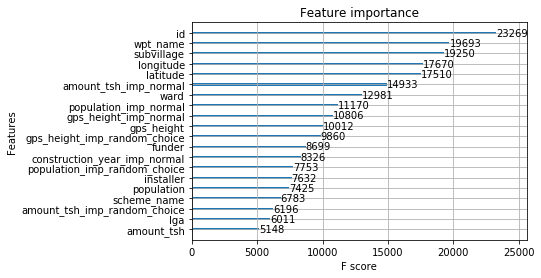

In [99]:
# Plot feature importance
plot_importance(model, max_num_features=20)
pyplot.show()

In [100]:
# Get prediction on test split

predictions = model.predict(X_test)

In [101]:
# Display distribution of predictions (where 0: functional, 1: non-functional, 2: functional needs repair)

display(np.unique(predictions))
display(collections.Counter(predictions))

array([0, 1, 2])

Counter({1: 6880, 0: 12137, 2: 585})

#### Evaluation

In [102]:
evaluation_params = {'ids': test_ids, 'true_values': Y_test, 'predictions': predictions, 
                     'algorithm': 'XGBoostClassifier', 'author': 'Rebecca', 
                     'params': params, 'processing_time': processing_time, 'notes': 'Data: All features, amount_tsh log scaled, cat features factorized'}
cr = evaluate(**evaluation_params)
'Classification Rate: {}'.format(cr)

'Classification Rate: 0.8064483215998367'

#### Confusion Matrix

In [103]:
# Confusion Matrix: Functional/Non-functional/Needs repair - Rows: True values, columns: Predicted values

confusion_matrix(Y_test, predictions, labels=[0, 1, 2])

array([[9647,  856,  142],
       [1656, 5797,   79],
       [ 834,  227,  364]])

#### Feature Selection - SelectFromModel

In [113]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier(**params)
    selection_model.fit(select_X_train, Y_train)
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(Y_test, predictions)
    display('Threshold: {}, n = {}, accuracy: {}'.format(thresh, select_X_train.shape[1], accuracy))
    feature_idx = selection.get_support()
    feature_name = X_train.columns[feature_idx]
    display('Selected feature names: {}'.format(feature_name))

'Threshold: 0.0, n = 52, accuracy: 0.8064483215998367'

"Selected feature names: Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'amount_tsh_imp_normal',\n       'amount_tsh_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'payment',

'Threshold: 0.0, n = 52, accuracy: 0.8064483215998367'

"Selected feature names: Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'amount_tsh_imp_normal',\n       'amount_tsh_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'payment',

'Threshold: 0.0, n = 52, accuracy: 0.8064483215998367'

"Selected feature names: Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'amount_tsh_imp_normal',\n       'amount_tsh_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'payment',

'Threshold: 0.006993968039751053, n = 49, accuracy: 0.8064483215998367'

"Selected feature names: Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'amount_tsh_imp_normal',\n       'amount_tsh_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'quality_g

'Threshold: 0.007182043045759201, n = 48, accuracy: 0.8044077134986226'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'amount_tsh_imp_normal',\n       'amount_tsh_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',

'Threshold: 0.0072789681144058704, n = 47, accuracy: 0.8069074584226099'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'amount_tsh_imp_normal',\n       'amount_tsh_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',

'Threshold: 0.007554375566542149, n = 46, accuracy: 0.8076216712580349'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'amount_tsh_imp_normal',\n       'operation_years', 'operation_years_imp_normal',\n       'operation_years_imp_random_choice', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class', 'source_type',\

'Threshold: 0.007650965824723244, n = 45, accuracy: 0.8056320783593511'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'population_imp_random_choice', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n   

'Threshold: 0.007769047282636166, n = 44, accuracy: 0.8080808080808081'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'subvillage', 'region', 'region_code',\n       'district_code', 'lga', 'ward', 'population', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'water_quality',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'construction_year_imp_normal', 'construction_year_imp_random_choice',\n       'operation_years', 'operation_years_imp_normal',\n       'operation_years_imp_random_choice', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class', 'source_type',\n       'management_group'],\n      dtype='object')"

'Threshold: 0.00789522286504507, n = 43, accuracy: 0.8076726864605652'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'gps_height_imp_random_choice', 'population_imp_normal',\n       'construction_year_imp_normal', 'construction_year_imp_random_choice',\n       'operation_years', 'operation_years_imp_normal',\n       'operation_years_imp_random_choice', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class', 'source_type',\n       'management_group'],\n      dtype='object')"

'Threshold: 0.007951653562486172, n = 42, accuracy: 0.8080808080808081'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'population_imp_normal', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'operation_years_imp_random_choice',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.008021753281354904, n = 41, accuracy: 0.8071115192327314'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'population_imp_normal', 'construction_year_imp_normal',\n       'construction_year_imp_random_choice', 'operation_years',\n       'operation_years_imp_normal', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class', 'source_type',\n       'management_group'],\n      dtype='object')"

'Threshold: 0.00808232557028532, n = 40, accuracy: 0.8101214161820223'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'population_imp_normal', 'construction_year_imp_normal',\n       'operation_years', 'operation_years_imp_normal',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.008379842154681683, n = 39, accuracy: 0.811396796245281'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'gps_height_imp_normal',\n       'construction_year_imp_normal', 'operation_years',\n       'operation_years_imp_normal', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class', 'source_type',\n       'management_group'],\n      dtype='object')"

'Threshold: 0.008429529145359993, n = 38, accuracy: 0.8110396898275686'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'construction_year_imp_normal',\n       'operation_years', 'operation_years_imp_normal',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.00843064021319151, n = 37, accuracy: 0.8126721763085399'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'construction_year_imp_normal',\n       'operation_years', 'extraction_type_group', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.009937625378370285, n = 36, accuracy: 0.8136414651566166'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'ward', 'population', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'operation_years',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.010044845752418041, n = 35, accuracy: 0.8129272523211917'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'population', 'public_meeting', 'scheme_management', 'scheme_name',\n       'permit', 'construction_year', 'extraction_type', 'management',\n       'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_normal',\n       'latitude_imp_random_choice', 'operation_years',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.010139097459614277, n = 34, accuracy: 0.8123150698908275'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'population', 'public_meeting', 'scheme_management', 'scheme_name',\n       'permit', 'construction_year', 'extraction_type', 'management',\n       'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal',\n       'longitude_imp_random_choice', 'latitude_imp_random_choice',\n       'operation_years', 'extraction_type_group', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.010515902191400528, n = 33, accuracy: 0.8141516171819202'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'population', 'public_meeting', 'scheme_management', 'scheme_name',\n       'permit', 'construction_year', 'extraction_type', 'management',\n       'payment_type', 'water_quality', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal', 'latitude_imp_random_choice',\n       'operation_years', 'extraction_type_group', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.010775857605040073, n = 32, accuracy: 0.8100704009794919'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'scheme_name', 'permit',\n       'construction_year', 'extraction_type', 'management', 'payment_type',\n       'water_quality', 'quantity', 'source', 'waterpoint_type',\n       'longitude_imp_normal', 'latitude_imp_random_choice', 'operation_years',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.011049479246139526, n = 31, accuracy: 0.8099173553719008'

"Selected feature names: Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',\n       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'scheme_name', 'permit',\n       'construction_year', 'extraction_type', 'management', 'payment_type',\n       'quantity', 'source', 'waterpoint_type', 'longitude_imp_normal',\n       'latitude_imp_random_choice', 'operation_years',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.011758173815906048, n = 30, accuracy: 0.8118559330680543'

"Selected feature names: Index(['amount_tsh', 'funder', 'installer', 'longitude', 'latitude', 'basin',\n       'region', 'region_code', 'district_code', 'lga', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal', 'latitude_imp_random_choice',\n       'operation_years', 'extraction_type_group', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.012167765758931637, n = 29, accuracy: 0.8121620242832364'

"Selected feature names: Index(['amount_tsh', 'funder', 'installer', 'longitude', 'latitude', 'basin',\n       'region', 'region_code', 'district_code', 'lga', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal', 'operation_years',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.012586463242769241, n = 28, accuracy: 0.8098153249668402'

"Selected feature names: Index(['amount_tsh', 'installer', 'longitude', 'latitude', 'basin', 'region',\n       'region_code', 'district_code', 'lga', 'public_meeting',\n       'scheme_management', 'scheme_name', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'longitude_imp_normal', 'operation_years',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.012979513965547085, n = 27, accuracy: 0.8107335986123865'

"Selected feature names: Index(['amount_tsh', 'longitude', 'latitude', 'basin', 'region', 'region_code',\n       'district_code', 'lga', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'quantity', 'source', 'waterpoint_type',\n       'longitude_imp_normal', 'operation_years', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class', 'source_type',\n       'management_group'],\n      dtype='object')"

'Threshold: 0.013146107085049152, n = 26, accuracy: 0.8097643097643098'

"Selected feature names: Index(['amount_tsh', 'longitude', 'latitude', 'basin', 'region', 'region_code',\n       'district_code', 'lga', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'quantity', 'source', 'waterpoint_type',\n       'operation_years', 'extraction_type_group', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.013220124877989292, n = 25, accuracy: 0.8066013672074278'

"Selected feature names: Index(['amount_tsh', 'longitude', 'basin', 'region', 'region_code',\n       'district_code', 'lga', 'public_meeting', 'scheme_management',\n       'scheme_name', 'permit', 'construction_year', 'extraction_type',\n       'management', 'payment_type', 'quantity', 'source', 'waterpoint_type',\n       'operation_years', 'extraction_type_group', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.014130844734609127, n = 24, accuracy: 0.8016018773594531'

"Selected feature names: Index(['amount_tsh', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'scheme_name', 'permit',\n       'construction_year', 'extraction_type', 'management', 'payment_type',\n       'quantity', 'source', 'waterpoint_type', 'operation_years',\n       'extraction_type_group', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type', 'management_group'],\n      dtype='object')"

'Threshold: 0.015202920883893967, n = 23, accuracy: 0.7977757371696765'

"Selected feature names: Index(['amount_tsh', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'operation_years', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class', 'source_type',\n       'management_group'],\n      dtype='object')"

'Threshold: 0.015261252410709858, n = 22, accuracy: 0.7985919804101622'

"Selected feature names: Index(['amount_tsh', 'basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'operation_years', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class',\n       'source_type'],\n      dtype='object')"

'Threshold: 0.01586507260799408, n = 21, accuracy: 0.7961432506887053'

"Selected feature names: Index(['basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'operation_years', 'extraction_type_group',\n       'extraction_type_class', 'quality_group', 'source_class',\n       'source_type'],\n      dtype='object')"

'Threshold: 0.01594691537320614, n = 20, accuracy: 0.7954290378532802'

"Selected feature names: Index(['basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'permit', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'operation_years', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type'],\n      dtype='object')"

'Threshold: 0.01626591756939888, n = 19, accuracy: 0.7953270074482196'

"Selected feature names: Index(['basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'scheme_management', 'construction_year',\n       'extraction_type', 'management', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'operation_years', 'extraction_type_class',\n       'quality_group', 'source_class', 'source_type'],\n      dtype='object')"

'Threshold: 0.016502518206834793, n = 18, accuracy: 0.7943577186001428'

"Selected feature names: Index(['basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'construction_year', 'extraction_type', 'management',\n       'payment_type', 'quantity', 'source', 'waterpoint_type',\n       'operation_years', 'extraction_type_class', 'quality_group',\n       'source_class', 'source_type'],\n      dtype='object')"

'Threshold: 0.01722828485071659, n = 17, accuracy: 0.7943577186001428'

"Selected feature names: Index(['basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'construction_year', 'extraction_type', 'management',\n       'payment_type', 'quantity', 'source', 'waterpoint_type',\n       'operation_years', 'extraction_type_class', 'quality_group',\n       'source_type'],\n      dtype='object')"

'Threshold: 0.017480768263339996, n = 16, accuracy: 0.7934904601571269'

"Selected feature names: Index(['basin', 'region', 'region_code', 'district_code', 'lga',\n       'public_meeting', 'construction_year', 'extraction_type', 'management',\n       'payment_type', 'quantity', 'source', 'waterpoint_type',\n       'operation_years', 'extraction_type_class', 'quality_group'],\n      dtype='object')"

'Threshold: 0.018553590402007103, n = 15, accuracy: 0.7935414753596571'

"Selected feature names: Index(['basin', 'region', 'region_code', 'lga', 'public_meeting',\n       'construction_year', 'extraction_type', 'management', 'payment_type',\n       'quantity', 'source', 'waterpoint_type', 'operation_years',\n       'extraction_type_class', 'quality_group'],\n      dtype='object')"

'Threshold: 0.019302235916256905, n = 14, accuracy: 0.7924701561065197'

"Selected feature names: Index(['basin', 'region', 'region_code', 'lga', 'public_meeting',\n       'construction_year', 'extraction_type', 'management', 'payment_type',\n       'quantity', 'source', 'waterpoint_type', 'extraction_type_class',\n       'quality_group'],\n      dtype='object')"

'Threshold: 0.019683942198753357, n = 13, accuracy: 0.7900214263850628'

"Selected feature names: Index(['basin', 'region', 'region_code', 'lga', 'public_meeting',\n       'construction_year', 'extraction_type', 'payment_type', 'quantity',\n       'source', 'waterpoint_type', 'extraction_type_class', 'quality_group'],\n      dtype='object')"

'Threshold: 0.02001677267253399, n = 12, accuracy: 0.7902765023977145'

"Selected feature names: Index(['basin', 'region', 'lga', 'public_meeting', 'construction_year',\n       'extraction_type', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'extraction_type_class', 'quality_group'],\n      dtype='object')"

'Threshold: 0.020810319110751152, n = 11, accuracy: 0.7885930007142128'

"Selected feature names: Index(['basin', 'region', 'lga', 'public_meeting', 'construction_year',\n       'extraction_type', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'extraction_type_class'],\n      dtype='object')"

'Threshold: 0.0209533479064703, n = 10, accuracy: 0.7879298030813182'

"Selected feature names: Index(['region', 'lga', 'public_meeting', 'construction_year',\n       'extraction_type', 'payment_type', 'quantity', 'source',\n       'waterpoint_type', 'extraction_type_class'],\n      dtype='object')"

'Threshold: 0.022397981956601143, n = 9, accuracy: 0.7789001122334456'

"Selected feature names: Index(['region', 'public_meeting', 'construction_year', 'extraction_type',\n       'payment_type', 'quantity', 'source', 'waterpoint_type',\n       'extraction_type_class'],\n      dtype='object')"

'Threshold: 0.023008890450000763, n = 8, accuracy: 0.7672686460565249'

"Selected feature names: Index(['region', 'public_meeting', 'construction_year', 'extraction_type',\n       'quantity', 'source', 'waterpoint_type', 'extraction_type_class'],\n      dtype='object')"

'Threshold: 0.024772511795163155, n = 7, accuracy: 0.7654831139679624'

"Selected feature names: Index(['region', 'construction_year', 'extraction_type', 'quantity', 'source',\n       'waterpoint_type', 'extraction_type_class'],\n      dtype='object')"

'Threshold: 0.025978798046708107, n = 6, accuracy: 0.7591062136516682'

"Selected feature names: Index(['region', 'construction_year', 'extraction_type', 'quantity',\n       'waterpoint_type', 'extraction_type_class'],\n      dtype='object')"

'Threshold: 0.030895685777068138, n = 5, accuracy: 0.7395163758800123'

"Selected feature names: Index(['region', 'extraction_type', 'quantity', 'waterpoint_type',\n       'extraction_type_class'],\n      dtype='object')"

'Threshold: 0.031788796186447144, n = 4, accuracy: 0.7359453117028875'

"Selected feature names: Index(['region', 'quantity', 'waterpoint_type', 'extraction_type_class'], dtype='object')"

'Threshold: 0.07391190528869629, n = 3, accuracy: 0.7097745128048158'

"Selected feature names: Index(['quantity', 'waterpoint_type', 'extraction_type_class'], dtype='object')"

'Threshold: 0.1069805696606636, n = 2, accuracy: 0.696102438526681'

"Selected feature names: Index(['quantity', 'extraction_type_class'], dtype='object')"

'Threshold: 0.15711890161037445, n = 1, accuracy: 0.6525354555657586'

"Selected feature names: Index(['quantity'], dtype='object')"

### One Vs All Approach

In [107]:
clf = OneVsRestClassifier(XGBClassifier(**params))
clf.fit(X_train, Y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, num_class=3, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          n_jobs=None)

In [108]:
predictions = clf.predict(X_test)

In [109]:
display(np.unique(predictions))
display(collections.Counter(predictions))

array([0, 1, 2])

Counter({1: 6505, 0: 11127, 2: 1970})

In [110]:
evaluation_params = {'ids': test_ids, 'true_values': Y_test, 'predictions': predictions, 
                     'algorithm': 'XGBoostClassifier', 'author': 'Rebecca', 
                     'params': params, 'processing_time': processing_time, 'notes': 'Data: All features, amount_tsh log scaled, cat features factorized, OneVsRest Approach'}
cr = evaluate(**evaluation_params)
'Classification Rate: {}'.format(cr)

'Classification Rate: 0.7839506172839507'

In [111]:
# Confusion Matrix: Functional/Non-functional/Needs repair - Rows: True values, columns: Predicted values

confusion_matrix(Y_test, predictions, labels=[0, 1, 2])

array([[9105,  703,  837],
       [1371, 5645,  516],
       [ 651,  157,  617]])